In [1]:
import numpy as np
import cv2 as cv
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [ ]:
#I guess do this for now?
tf.config.run_functions_eagerly(False)

In [2]:
#better; in order

def load_marsh_images(folder):
    images = []
    
    for i in range(1,12):
        img = cv.imread(os.path.join(folder,"Band%d.jpg" % i))
        print("Band%d.jpg" % i)
        if img is not None:
            images.append(img)
    return images
    
    #for filename in os.listdir(folder):
    #    img = cv.imread(os.path.join(folder,filename))
    #    if img is not None:
    #        images.append(img)
    #return images




In [3]:
marsh_images = load_marsh_images("train_jpg")
#try converting to greyscale 


Band1.jpg
Band2.jpg
Band3.jpg
Band4.jpg
Band5.jpg
Band6.jpg
Band7.jpg
Band8.jpg
Band9.jpg
Band10.jpg
Band11.jpg


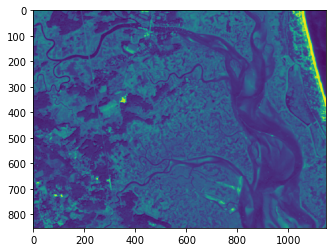

In [4]:
#convert to grayscale 
#gray_marsh = cv.cvtColor(marsh_images[7], cv.COLOR_BGR2GRAY)
#plt.imshow(gray_marsh)

marsh_images_gray = []
for im in marsh_images:
    marsh_images_gray.append(cv.cvtColor(im, cv.COLOR_BGR2GRAY))
plt.imshow(marsh_images_gray[7])

In [5]:
marsh_mask = cv.imread("marsh_mask.jpg")
gray_mask = cv.cvtColor(marsh_mask, cv.COLOR_BGR2GRAY)

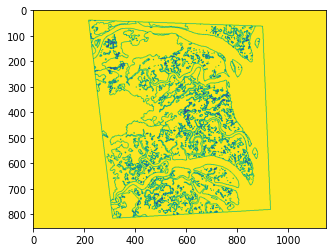

In [6]:
plt.imshow(gray_mask)

# Preliminary attempt 

Use many crops of the images/labels as training data for u-nets. Train to guess boundary or not boundary (at first). 

Issues to be solved: 

1. The solutions need to be stiched together somehow. 
2. The solution does not automatically output a curve - the boundary can be wider than 1.
3. The solution does not know what is marsh, water, etc. A solution to this might be to instead output three classes, then compare the boundary.
4. The mask only covers part of the image and has a weird shape. Also the parallelogram is included, which it shouldn't be. I think the right thing to do is to somehow mask off what's outside the parallelogram. 
5. Can't use any pre-trained u-net out of the box because of the extra image bands - need one with enough channels.

## Extracting patches

In [7]:
# get many crops as training data. 
#dtype=tf.float32

image = tf.convert_to_tensor(marsh_images_gray, dtype =tf.float32)/255.0

BANDS, HEIGHT,WIDTH = image.shape

reshaped_image = tf.transpose(image, perm=[1,2,0])



reshaped_image = tf.reshape(reshaped_image,[1,HEIGHT,WIDTH,BANDS])
#check shape 
#print(reshaped_image.shape)
#plt.imshow(reshaped_image.numpy()[0,:,:,10])

#small data set for now
PATCH_SIZE = 128
PATCH_STRIDE = 30

patches = tf.image.extract_patches(images=reshaped_image,
                           sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
                           strides=[1, PATCH_STRIDE, PATCH_STRIDE, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')


patches = tf.reshape(patches,[-1,PATCH_SIZE,PATCH_SIZE,BANDS])

#plt.imshow(patches.numpy()[24,:,:,22])


num_patches = patches.shape[0]

#same for mask 

mask_image = tf.convert_to_tensor(gray_mask, dtype =tf.float32)/255.0

reshaped_mask = tf.reshape(mask_image,[1,HEIGHT,WIDTH,1])

mask_patches = tf.image.extract_patches(images=reshaped_mask,
                           sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
                           strides=[1, PATCH_STRIDE, PATCH_STRIDE, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')


mask_patches = tf.reshape(mask_patches,[-1,PATCH_SIZE,PATCH_SIZE,1])


#plt.imshow(mask_patches.numpy()[24,:,:,0])

2022-01-30 16:40:53.601656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-30 16:40:53.601972: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


<Figure size 432x288 with 0 Axes>

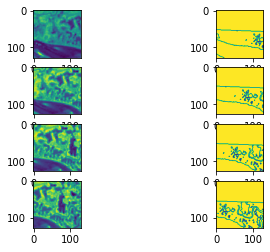

In [8]:
#make sure they line up
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(4,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(4):
    axarr[i][0].imshow(patches.numpy()[20 + i,:,:,7])
    axarr[i][1].imshow(mask_patches.numpy()[20 + i,:,:,0])

## Training from patches 

In [9]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output



In [10]:
mask_patches.shape

TensorShape([875, 128, 128, 1])

In [11]:
#do a 50-50 split for now - top half of image
TRAIN_RATIO = 2
TRAIN_LENGTH = num_patches//TRAIN_RATIO
BATCH_SIZE = 64
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [12]:
#define train_images 

#I need to convert to a tensorflow dataset, I guess. 

#so right now I just have a big tensor. Need to say X_train = one part, y_train = another part.

#patches.shape

patch_dataset = tf.data.Dataset.from_tensor_slices((patches,mask_patches))


patch_dataset

<TensorSliceDataset shapes: ((128, 128, 11), (128, 128, 1)), types: (tf.float32, tf.float32)>

In [13]:
#batches

train_batches = (
    patch_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

#test_batches = test_images.batch(BATCH_SIZE)

# Creating the model
I used the same neural network from the tutorial but with a 1x1 convolution to change the number of channels.

In [16]:
#tried to use mobilenet with more channels, got issues.

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [17]:
# try to implement mobilenet (or something like it) myself. 
# for now just try to guess if mask/not mask?
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [14]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 11])

    #try to do a 1x1 convolution to get it down to size.
    #reduce_channel = tf.keras.layers.Conv2D(3,1,1,activation="relu")(inputs)
    reduce_channel = tf.keras.layers.Conv2D(3,1,1,activation="relu")(inputs)
  # Downsampling through the model
    #skips = down_stack(inputs)
    skips = down_stack(reduce_channel)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 11 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 3)  36          input_3[0][0]                    
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     conv2d_1[0][0]                   
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
____________________________________________________________________________________________

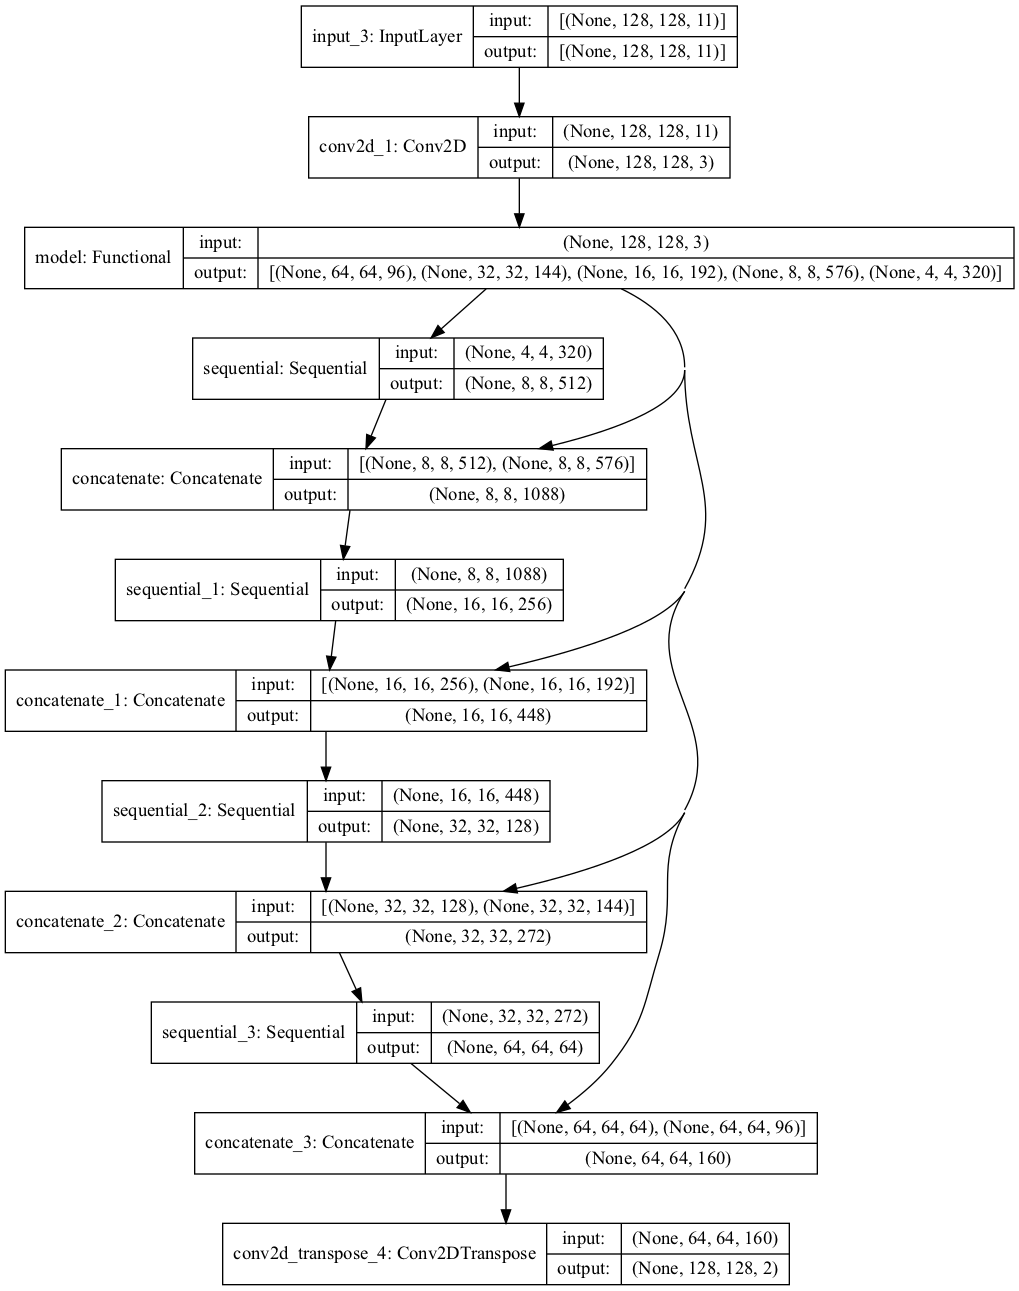

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Testing the model

Try out the model to check what it predicts before training.

In [30]:
#for images, masks in train_batches.take(2):
#  sample_image, sample_mask = images[0], masks[0]
#  display([sample_image, sample_mask])

for patch,mask in patch_dataset.take(550):
    sample_image,sample_mask = patch, mask
#for mask in mask_dataset.take(40):
#    sample_mask = mask



In [22]:
#to show the 
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i][:,:,:3]))
    plt.axis('off')
  plt.show()

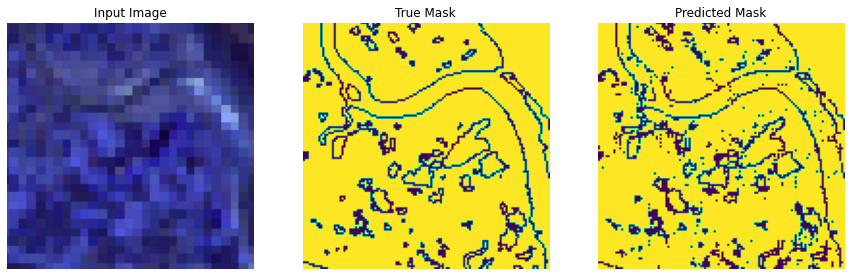

In [31]:
#im = patch[:,:,:3]
#im.shape
show_predictions()

#wow, it actually does something!!! 

# Training the model

Going to give it a shot. 

In [24]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

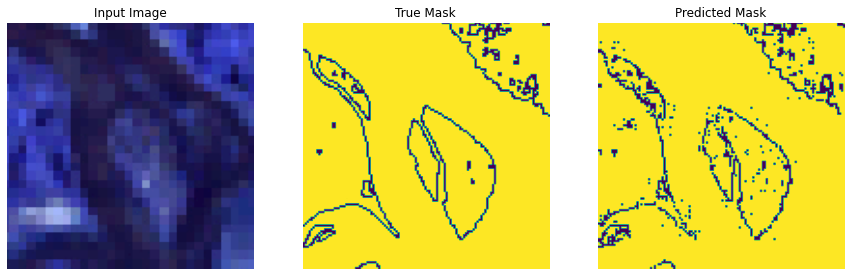


Sample Prediction after epoch 1000



In [25]:
EPOCHS = 1000
#VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS



model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          #validation_data=test_batches,
                          callbacks=[DisplayCallback()]
                         )

In [ ]:
# it does seem to be doing way better. but why is it oscillating between epochs? 
#I think we need to do something about the issue with some having masks and some not
#also we need to look at test data, not just data that's used to train 

# Troubleshooting memory usage 



In [ ]:
import os
# Get file size in bytes for a given model
os.stat('model.h5').st_size